In [87]:
pip install pycm

     ---------------------------------------- 66.1/66.1 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 595.7/595.7 kB 9.3 MB/s eta 0:00:00




[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
# %matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import os
os.chdir('C:/Lehigh/Rick- Anomaly Detection/Code')

In [14]:
df = pd.read_csv("C:/Lehigh/Rick- Anomaly Detection/CNN-KF/CNN-KF/Clean_data.csv", index_col='Epoch')

df = df.rename({'InVehicle_Longitudinal_Speed':'inveh_long_spd', 'GPS_Speed': 'gps_speed', 'InVehicle_Longitudinal_Accel': 'inveh_long_acc'}, axis = 1)

df = df.dropna()

In [15]:
simulated_df = pd.read_csv("C:/Lehigh/Rick- Anomaly Detection/CNN-KF/CNN-KF/Instant attack/25/Sensor3_values_instant_25.csv", index_col = 'Unnamed: 0')
simulated_gt = pd.read_csv("C:/Lehigh/Rick- Anomaly Detection/CNN-KF/CNN-KF/Instant attack/25/Ground_truth_test_set_instant_25_sensor3.csv")

In [29]:
# Assuming last 5958 rows of Sensor3_values_instant_25.csv belongs to test samples

simulated_df_test = simulated_df.iloc[-simulated_gt.shape[0]:]
simulated_df_test = simulated_df_test.rename({'InVehicle_Longitudinal_Speed':'inveh_long_spd', 'GPS_Speed': 'gps_speed', 'InVehicle_Longitudinal_Accel': 'inveh_long_acc'}, axis = 1)

In [7]:
df.describe

<bound method NDFrame.describe of          inveh_long_spd  gps_speed  inveh_long_acc
Epoch                                             
0.0           11.375000  11.307097       -0.103000
1.0           11.366708  11.255964       -0.353946
2.0           11.362331  11.249115       -0.090962
3.0           11.358665  11.263280       -0.043470
4.0           11.356745  11.270361       -0.037579
...                 ...        ...             ...
29995.0       21.885911  22.183436        0.181791
29996.0       21.902474  22.201933        0.225397
29997.0       21.919066  22.237784        0.204812
29998.0       21.937178  22.255482        0.252680
29999.0       21.956401  22.256597        0.240447

[30000 rows x 3 columns]>

In [37]:
train_size = 24041
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], simulated_df_test
print(train.shape, test.shape)

(24041, 3) (5958, 3)


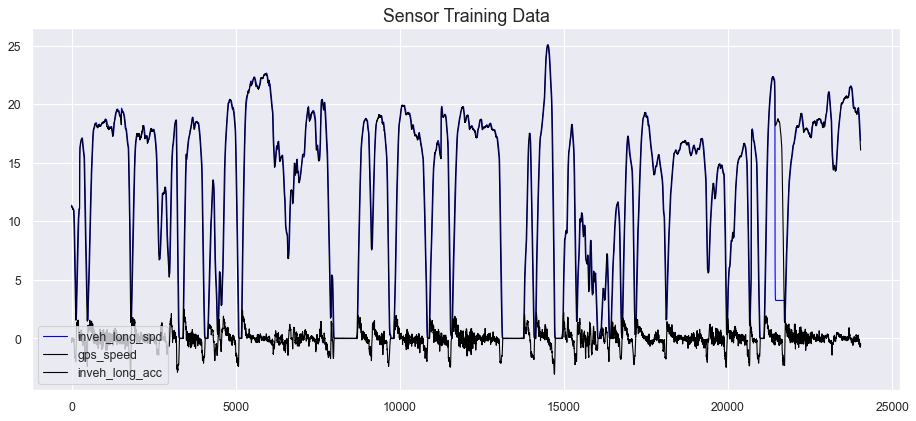

In [38]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['inveh_long_spd'], label='inveh_long_spd', color='blue', animated = True, linewidth=1)
# ax.plot(train['GpsHeading'], label='GpsHeading', color='red', animated = True, linewidth=1)
# ax.plot(train['Latitude'], label='Latitude', color='green', animated = True, linewidth=1)
ax.plot(train['gps_speed'], label='gps_speed', color='black', animated = True, linewidth=1)
ax.plot(train['inveh_long_acc'], label='inveh_long_acc', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

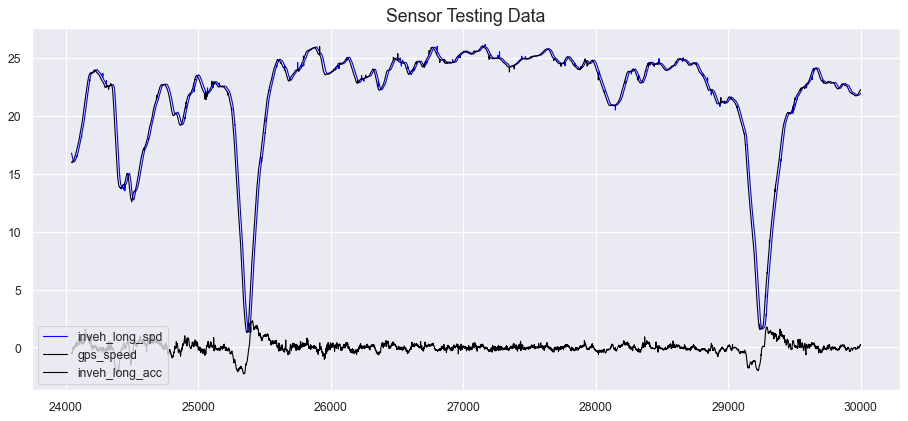

In [39]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['inveh_long_spd'], label='inveh_long_spd', color='blue', animated = True, linewidth=1)
# ax.plot(test['GpsHeading'], label='GpsHeading', color='red', animated = True, linewidth=1)
# ax.plot(test['Latitude'], label='Latitude', color='green', animated = True, linewidth=1)
ax.plot(test['gps_speed'], label='gps_speed', color='black', animated = True, linewidth=1)
ax.plot(test['inveh_long_acc'], label='inveh_long_acc', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Testing Data', fontsize=16)
plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [41]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (24041, 1, 3)
Test data shape: (5958, 1, 3)


In [42]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [43]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [44]:
nb_epochs = 30
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

Epoch 1/30
2164/2164 [==============================] - 30s 8ms/step - loss: 0.2689 - val_loss: 0.0106
Epoch 2/30
2164/2164 [==============================] - 16s 7ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 3/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 4/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 5/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 6/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 7/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 8/30
2164/2164 [==============================] - 14s 7ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 9/30
2164/2164 [==============================] - 15s 7ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 10/30
2164/2164 [==============================] - 15s 7ms/step - l

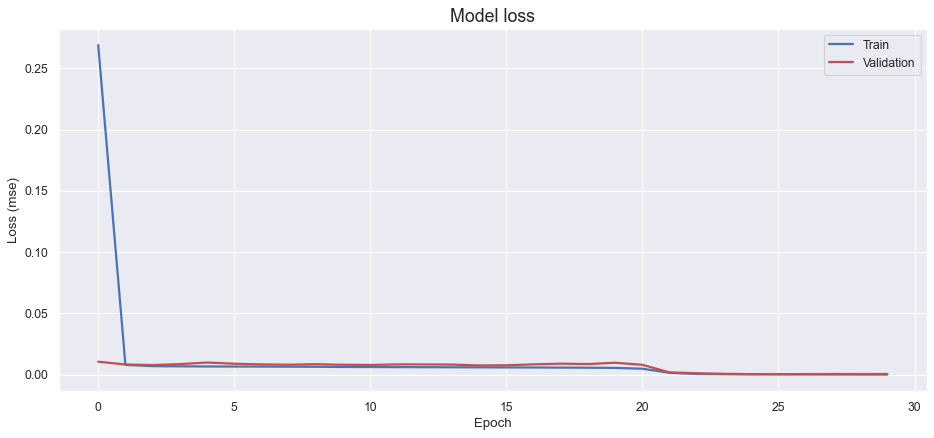

In [45]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [52]:
X_train

array([[[-0.44147637, -0.4676297 , -0.13125124]],

       [[-0.44259269, -0.47458843, -0.50417658]],

       [[-0.44318201, -0.47552043, -0.11336178]],

       ...,

       [[ 0.31553983,  0.19166623, -0.90955041]],

       [[ 0.30753816,  0.1848595 , -0.79275106]],

       [[ 0.2997785 ,  0.18246114, -0.62183136]]])

In [53]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index
scored = pd.DataFrame(index=train.index)
scored

752/752 [==============================] - 3s 3ms/step


""
Epoch
0.0
1.0
2.0
3.0
4.0
...
24036.0
24037.0
24038.0


752/752 [==============================] - 3s 3ms/step


C:\Users\Basant Kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

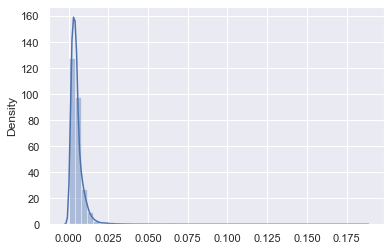

In [54]:
import seaborn as sns
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
Loss_mse = np.mean(np.abs(X_pred-Xtrain), axis = 1)

sns.distplot(Loss_mse, bins=50, kde= True)

In [68]:
threshold = np.percentile(Loss_mse, 99)

In [69]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mse'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mse'] > scored['Threshold']
scored.head()

187/187 [==============================] - 1s 4ms/step


,Loss_mse,Threshold,Anomaly
24042,0.002545,0.02299,False
24043,0.002336,0.02299,False
24044,0.002573,0.02299,False
24045,0.002329,0.02299,False
24046,0.001636,0.02299,False


<AxesSubplot:>

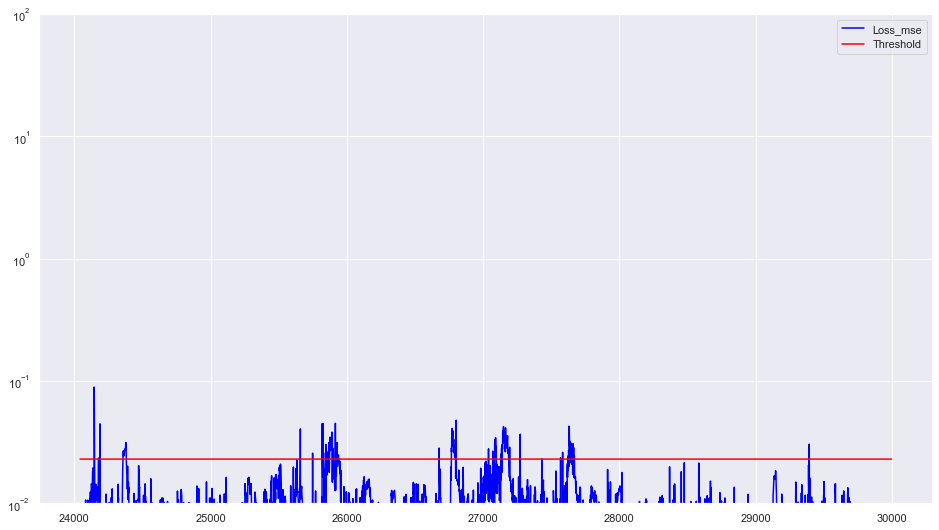

In [70]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [82]:
scored['Anomaly'] = scored['Anomaly'].astype(int)
y_actual = list(simulated_gt['0.000000000000000000e+00'].astype(int))
y_predicted = list(scored['Anomaly'])

y_predicted

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [94]:
# from sklearn import metrics
# cm1 = metrics.confusion_matrix(y_actual, y_predicted)

from pycm import *

cm2 = ConfusionMatrix(actual_vector=y_actual, predict_vector=y_predicted) # Create CM From Data
print(cm2)

Predict    0          1          
Actual
0          4742       191        

1          982        43         





Overall Statistics : 

95% CI                                                            (0.79302,0.81322)
ACC Macro                                                         0.80312
ARI                                                               0.00349
AUNP                                                              0.50162
AUNU                                                              0.50162
Bangdiwala B                                                      0.78972
Bennett S                                                         0.60624
CBA                                                               0.4352
CSI                                                               0.00772
Chi-Squared                                                       0.235
Chi-Squared DF                                                    1
Conditional Entropy                            